<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: A self-help tool for couples to understand their attachment style

## Contents:
- [Data Cleaning](#Data-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Modelling](#Data-Modelling)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

## Import libraries

In [1]:
import pandas as pd
import string
import nltk
import re
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

import pickle

In [2]:
# Set display to show all columns and rows, and contents in the column
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

## Data Cleaning

### Import Data

In [3]:
# Import data from our web scrapping jupyter notebook
df = pd.read_csv("../data/df.csv")

In [4]:
# Class 0 = Avoidant
# Class 1 = Anxious

df.sample(5)

,Unnamed: 0,Title,Post Text,ID,Score,Total Comments,Post URL,subreddit,class
193,193,Do your attachment wounds kick in more when someone doesn't respond well to bids? {FA},"If you aren't familiar, bids for connection comes from Dr John Gottman's work. Here's a brief description. ([Full article](https://www.gottman.com/blog/want-to-improve-your-relationship-start-paying-more-attention-to-bids/))\n\n*""Gottman refers to bids as “the fundamental unit of emotional communication.” Bids can be small or big, verbal or nonverbal. They’re requests to connect. They might take the form of an expression, question, or physical outreach. They can be funny, serious, or sexual in nature.*\n\n*For example, your partner might say, “Hey, whatever happened with that situation at work with your manager?” or, “Do you want to talk about our plans this weekend?” or simply, “Can you pass the water?*\n\n*...*\n\n*There are three ways you can respond to a bid:*\n\n1. *Turning towards (acknowledging the bid)*\n2. *Turning away (ignoring or missing the bid)*\n3. *Turning against (rejecting the bid in an argumentative or belligerent way)""*\n\n&#x200B;\n\nI shared the above article with my boyfriend. Every now and then one or both of us will mention bids. ""I'm making a bid."" or ""Respond positively to my bid!"" It's definitely in a positive way, and something we now use to connect more. \n\nBut since sharing it with him, I'm realizing that first of all - literally everything is a bid. It obviously doesn't just reply to romantic relationships. I've tried to look at my kids in this context and not get frustrated because they're just making bids for connection. It's helped, but I have more work to do. \n\nSecond is that when someone responds by turning away or turning against multiple bids in a row, I'm instantly triggered into my attachment wounding. Especially as a hypervigilant FA. I notice literally everything. And I know you aren't supposed to but I can't help but 'keep score' in the sense that I know when it's happened more than once in a row. \n\nThinking back to my childhood, I feel like it was really rare that as a kid my parents turned towards my bids. My boyfriend asked me last night to share a childhood memory and I struggle to come up with one that involves my parents (unless it was a traumatizing event). I feel like I spent a majority of my childhood fending for myself. So I guess it would make sense that someone turning away/against a bid would trigger my attachment wounds. \n\nI wonder if anyone else notices this too?",v6xjhz,47,14,https://www.reddit.com/r/AvoidantAttachment/comments/v6xjhz/do_your_attachment_wounds_kick_in_more_when/,AvoidantAttachment,0
2688,1333,Is it the person or what they represent that I'm getting triggered by?,"It's funny how it feels like it's been ages since I cut contact with this person. It's only been 3 weeks. Today I got very strong urges to reach out. The moment I went to do it it's like my body began turning on itself (almost as a warning that I was about to abandon myself)\n\nImmediately I got severe stomach cramps, nausea, and fatigue. I didn't reach out because of that bad reaction, and a few minutes after I got off the unblock screen I went back to normal. I noticed this happened right before I stopped talking to them the first time too.\n\n I felt sick because I was stuck in anxious limbo having them around. Within a week I went through a process of deleting everything I had of them and contemplating if I was ready to never hear from them again. Once I made my decision to block them, I felt regulated and safe. \n\nI had trouble focusing for the first few days but my appetite was fine and I didn't feel sick. So I just want to know, is it the person I'm afraid of or the representation of my fears that I'm afraid of?",12d1hkd,8,16,https://www.reddit.com/r/AnxiousAttachment/comments/12d1hkd/is_it_the_person_or_what_they_represent_that_im/,AnxiousAttachment,1
315,315,Has anyone felt like they were in love wit

In [5]:
# Rename the 'Title' column
df.rename(columns={
    'Title': 'text'
}, inplace=True)

In [6]:
# Check that the X values ('text' column) and y values ('class' column) do not have missing values
df.isnull().sum()

Unnamed: 0          0
text                0
Post Text         336
ID                  0
Score               0
Total Comments      0
Post URL            0
subreddit           0
class               0
dtype: int64

In [7]:
# Check the number of rows for each class
df["class"].value_counts()

1    1811
0    1355
Name: class, dtype: int64

In [8]:
# Summary statistics
df.describe()

,Unnamed: 0,Score,Total Comments,class
count,3166.000000,3166.000000,3166.000000,3166.000000
mean,807.419457,42.188566,17.218572,0.572015
std,484.376411,60.832831,23.687478,0.494865
min,0.000000,0.000000,0.000000,0.000000
25%,395.250000,11.000000,5.000000,0.000000
50%,791.000000,26.000000,11.000000,1.000000
75%,1186.750000,48.000000,21.000000,1.000000
max,1810.000000,983.000000,383.000000,1.000000


### Preprocessing

Below are the three main preprocessing processes performed:

#### Tokenising
The process of breaking down text into word chunks.

#### Lemmatisation
The process of simplifying words. Based on our initial studies, we found that Lemmatisation performed better than Stemming. The results after stemming were excluded from this notebook.

#### Removal of stopwords
The process of removing common words to reduce noise.

#### Remove special characters

In [9]:
# Remove punctuations and standardise to lowercase

def remove_punct(text):
    # store character only if it is not a punctuation
    text_nopunct = "".join([char for char in text if char not in string.punctuation])
    return text_nopunct

df["text_clean"] = df["text"].apply(lambda x: remove_punct(x.lower()))
df[["text", "text_clean"]].sample(10)

,text,text_clean
758,Weekly Relationship Thread: Ask Avoidants,weekly relationship thread ask avoidants
1332,What does it mean to lean DA/AP as a FA? {fa},what does it mean to lean daap as a fa fa
1008,Time to break up? unsure if {DA} or FA,time to break up unsure if da or fa
1618,So f**ckin tired of this attachment style - A vent.,so fckin tired of this attachment style a vent
1779,"Secure people who used to be anxious, how did you do it?",secure people who used to be anxious how did you do it
2387,Weekly Thread - Questions about Anxious Attachment?,weekly thread questions about anxious attachment
1063,{FA} Suddenly insecure about my looks?,fa suddenly insecure about my looks
2434,Weekly Thread - Questions about Anxious Attachment?,weekly thread questions about anxious attachment
134,Feel myself getting the ick {FA},feel myself getting the ick fa
2235,being secure doesn't mean you don't grieve,being secure doesnt mean you dont grieve


#### Remove URLs

In [10]:
# Remove urls in the text column

def remove_url(text):
    text_nourl = re.sub(r'\S*http\S*', '', text)
    return text_nourl

df["text_clean"] = df["text_clean"].apply(lambda x: remove_url(x))

df[["text", "text_clean"]].sample(10)

,text,text_clean
301,{da} One reason why I wouldn’t be ready for a relationship…,da one reason why i wouldn’t be ready for a relationship…
225,How avoidance releases dopamine {DA} {FA} such a fascinating read!,how avoidance releases dopamine da fa such a fascinating read
3005,Got my stuff back from DA,got my stuff back from da
2227,Set clear boundaries and I feel proud of myself... (for the time being),set clear boundaries and i feel proud of myself for the time being
2818,One month post breakup with DA,one month post breakup with da
833,"Avoidants, what’s your ideal relationship?",avoidants what’s your ideal relationship
532,Manipulating flair to skirt rules will not be tolerated {AP},manipulating flair to skirt rules will not be tolerated ap
1610,AVOIDANT SUB IS SCARY AF (RANT),avoidant sub is scary af rant
543,Being unforgiving as an FA,being unforgiving as an fa
2711,How do I focus on myself without losing my bf?,how do i focus on myself without losing my bf


#### Remove words that contains digit

In [11]:
def remove_digit(text):
    text_nodigit = re.sub(r'\w*\d\w*', '', text)
    return text_nodigit

df["text_clean"] = df["text_clean"].apply(lambda x: remove_digit(x))

df[["text", "text_clean"]].sample(10)

,text,text_clean
3001,Got dumped by an emotionally unavailable man again..,got dumped by an emotionally unavailable man again
2190,How to enjoy dating someone you really like as an AA,how to enjoy dating someone you really like as an aa
979,What is what define us? The inside or the outside?,what is what define us the inside or the outside
1123,Should I {fa} stay or should I go?,should i fa stay or should i go
1333,{fa} Are you an only child?,fa are you an only child
2038,How to stop ruminating on relationship mistakes + ghosting?,how to stop ruminating on relationship mistakes ghosting
2348,I think we can all relate to this :D,i think we can all relate to this d
1419,Secure attachment feels like a dream,secure attachment feels like a dream
2234,My (37F) first healthy-feeling relationship (43M) ended and I’m wrecked yet also somehow ok,my first healthyfeeling relationship ended and i’m wrecked yet also somehow ok
2264,Does anyone else start to feel resentment towards their partner?,does anyone else start to feel resentment towards their partner


#### Tokenize

In [12]:
def tokenize(text):  
    # /W matches any character that is neither alphanumeric nor underscore
    # Add a + just in case there are 2 or more spaces between certain words
    tokens = re.split('\W+', text)
    return tokens

df["text_token"] = df["text_clean"].apply(lambda x: tokenize(x)) 
df[["text", "text_token"]].sample(10)

,text,text_token
1313,"{fa} {da} I think I’m an FA, not a DA","[fa, da, i, think, i, m, an, fa, not, a, da]"
1665,Detachment,[detachment]
1152,Therapy {da},"[therapy, da]"
1166,{FA} Question to fellow FA leaning DA - deactivating with friendships,"[fa, question, to, fellow, fa, leaning, da, deactivating, with, friendships]"
1177,"{FA} single for so long, unsure how to operate in a relationship","[fa, single, for, so, long, unsure, how, to, operate, in, a, relationship]"
20,I {FA} never felt so attacked lol,"[i, fa, never, felt, so, attacked, lol]"
1209,Rant {fa},"[rant, fa]"
2628,"I need help, anxiety going crazy","[i, need, help, anxiety, going, crazy]"
1980,Finding “the one”,"[finding, the, one, ]"
2925,Do ex's with avoidant attachment styles come back after ending short relationships? Advice to keep moving on?,"[do, exs, with, avoidant, attachment, styles, come, back, after, ending, short, relationships, advice, to, keep, moving, on]"


#### Remove Stopwords

In [13]:
# List of default stopwords
stopword = nltk.corpus.stopwords.words('english')

# Remove stop words
def remove_stopwords(tokenized_list):
    #Store in text only if word is not found in stopword i.e. it is not a stopword
    text = [word for word in tokenized_list if word not in stopword]
    return text

df["text_stop"] = df["text_token"].apply(lambda x: remove_stopwords(x))
df[["text", "text_stop"]].sample(10)

,text,text_stop
322,having a really hard time with feeling like I desire to leave {fa},"[really, hard, time, feeling, like, desire, leave, fa]"
2926,Sometimes I wanna be a DA for day,"[sometimes, wanna, da, day]"
6,How many people have we made confused lol,"[many, people, made, confused, lol]"
14,Ignorance really is bliss,"[ignorance, really, bliss]"
1009,How much time to spend with someone new? {fa},"[much, time, spend, someone, new, fa]"
2316,Avoidant bf - broken up for good,"[avoidant, bf, broken, good]"
2496,Anxious mother advice,"[anxious, mother, advice]"
2430,Weekly Thread - Relationship/Dating/Breakup Advice,"[weekly, thread, relationshipdatingbreakup, advice]"
884,Relationship Accommodations {da},"[relationship, accommodations, da]"
1015,What the hell is wrong with me? {DA},"[hell, wrong, da]"


#### Lemmatize

In [14]:
# Lemmatizer
wn = nltk.WordNetLemmatizer()

def lemmatizing(tokenized_text):
    #return list of all lemmatized words for their corresponding words in tokenized_text
    text = [wn.lemmatize(word) for word in tokenized_text]
    return ' '.join(text)

df["text_lemmatise"] = df["text_stop"].apply(lambda x: lemmatizing(x))
df[["text", "text_lemmatise"]].sample(10)

,text,text_lemmatise
1325,{fa} Identifying deactivation,fa identifying deactivation
1248,{FA} How to strengthen my relationship with my university friends/classmates?,fa strengthen relationship university friendsclassmates
1696,DAs just don’t like us that much,da like u much
1443,I need space VS I need to talk,need space v need talk
2477,REMINDER - Moving to an Approved user system for posting,reminder moving approved user system posting
2817,"Love is truly the worst drug, is it not?",love truly worst drug
776,DA to oversharer — where is the line?,da oversharer line
1749,being with a DA is lonelier than being alone,da lonelier alone
2426,"Triggered, but not able to put my finger on why.",triggered able put finger
1449,The biggest difference between dating secure men vs avoidant men,biggest difference dating secure men v avoidant men


#### Remove duplicate words

In [15]:
from nltk.tokenize import word_tokenize
df_1 = df[df["class"]==1]
df_0 = df[df["class"]==0]
class_text_1 = df_1["text_lemmatise"].tolist()

# Tokenize the text in the df
tokens_class_1 = []
for text in class_text_1:
    tokens_class_1.extend(word_tokenize(text))
class_text_0 = df_0["text_lemmatise"].tolist()

# Tokenize the text in the df
tokens_class_0 = []
for text in class_text_0:
    tokens_class_0.extend(word_tokenize(text))

# Reset Index
class_0_df =  pd.DataFrame(tokens_class_0).reset_index()
class_0_df.head()
class_0_df.columns = ['index',"words"]

# Group class 0 data by words
final_class_0 = pd.DataFrame(class_0_df.groupby("words")["words"].count().sort_values(ascending=False))
final_class_0.columns = ["count_of_class_0"]
final_class_0 = final_class_0.reset_index()

# Reset Index
class_1_df =  pd.DataFrame(tokens_class_1).reset_index()
class_1_df.head()
class_1_df.columns = ['index',"words"]

# Group class 1 data by words
final_class_1 = pd.DataFrame(class_1_df.groupby("words")["words"].count().sort_values(ascending=False))
final_class_1.columns = ["count_of_class_1"]
final_class_1 = final_class_1.reset_index()

In [16]:
# Merge both class 0 and class 1 and remove duplicated words between both classes
duplicate_words_df = pd.merge(final_class_0,final_class_1,how ="inner",on = "words")
duplicate_words_df['count_diff'] = (duplicate_words_df['count_of_class_0']- duplicate_words_df['count_of_class_1']).abs()
duplicate_words_df.columns=['Duplicate Words','Count (Class 0)', 'Count (Class 1)', 'Count Difference']

# Sort the DataFrame by the 'Count Difference' column in ascending order
duplicate_words_df = duplicate_words_df.sort_values(by='Count Difference',ascending=False)

duplicate_words_df

,Duplicate Words,Count (Class 0),Count (Class 1),Count Difference
0,fa,720,21,699
1,da,479,101,378
67,anxious,15,201,186
4,attachment,101,196,95
40,secure,22,97,75
5,avoidants,91,27,64
64,ex,16,74,58
75,anxiety,14,64,50
800,aa,1,49,48
32,dating,26,73,47


In [17]:
from nltk.tokenize import word_tokenize

class_0_text = df[df["class"] == 0]["text_lemmatise"].tolist()
class_1_text = df[df["class"] == 1]["text_lemmatise"].tolist()
# Tokenize the post text for class 1
tokens_class_1 = []
for text in class_1_text:
    tokens_class_1.extend(word_tokenize(text))
# Tokenize the post text for class 0    
tokens_class_0 = []
for text in class_0_text:
    tokens_class_0.extend(word_tokenize(text))
    
unique_tokens_class_1 = set(tokens_class_1)
unique_tokens_class_0 = set(tokens_class_0)

print(f"Unique words in class 0: {len(unique_tokens_class_0)-len(duplicate_words_df)}")
print(f"Unique words in class 1: {len(unique_tokens_class_1)-len(duplicate_words_df)}")
print(f"Duplicate words in both classes: {len(duplicate_words_df)}")

Unique words in class 0: 904
Unique words in class 1: 1093
Duplicate words in both classes: 1050


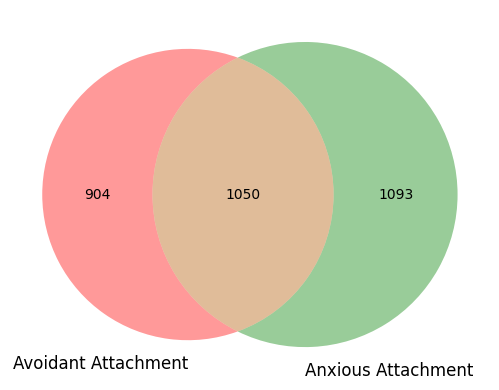

In [18]:
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

venn2(subsets = (904,1093,1050), set_labels = ('Avoidant Attachment', 'Anxious Attachment'));

As seen in the Venn diagram above, about 50% of words in each subreddit overlaps with the other. In addition, the overlapping words have differing frequencies in each subreddit (e.g. an overlapping word may predominately appear only in one subreddit). For accurate NLP model performance, 90% of the overlapping words with the lowest frequency difference (i.e. almost equal appearance count in both subreddits) were removed.

In [19]:
# Remove list of duplicate words that has count difference of 10 and below due to its insignificance in NLP

additional_stopwords = duplicate_words_df[duplicate_words_df['Count Difference'].between(0, 10)]
stopword += additional_stopwords["Duplicate Words"].tolist()

df["text_final"] = df["text_token"].apply(lambda x: remove_stopwords(x))
df["text_final"] = df["text_final"].apply(lambda x: lemmatizing(x))

In [20]:
# These stopwords will be removed from df 
additional_stopwords.shape

(972, 4)

#### Data for modelling

In [21]:
# df after cleaning
df.head()

,Unnamed: 0,text,Post Text,ID,Score,Total Comments,Post URL,subreddit,class,text_clean,text_token,text_stop,text_lemmatise,text_final
0,0,Seriously though {FA}{DA},NaN,tqnp1u,521,19,https://i.redd.it/vv5etnapy7q81.jpg,AvoidantAttachment,0,seriously though fada,"[seriously, though, fada]","[seriously, though, fada]",seriously though fada,fada
1,1,For all my favorite avoidants ❤️,NaN,rpvbi1,453,2,https://i.redd.it/8yz268zr05881.jpg,AvoidantAttachment,0,for all my favorite avoidants ❤️,"[for, all, my, favorite, avoidants, ]","[favorite, avoidants, ]",favorite avoidants,avoidants
2,2,Anxious People on this subreddit: stop abandoning yourself and blaming it on someone else,"If you’re anxious preoccupied or anxious leaning whatever, by hyperfocusing on everyone else, figuring out an avoidant, dissecting someone else’s brain, spending all your time researching THEM, you’re abandoning and avoiding yourself. \n\nEvery time you choose to not voice a need in fear they’ll run, YOU are abandoning YOURSELF. Sticking around repeatedly after your voiced needs aren’t being met? Choosing to stick around for someone who has been ignoring you for months? YOU are abandoning YOURSELF. You can make it about the avoidant’s attachment style all you want but then you’re being avoidant to yourself all over again. Double whammy. There really are so many avoidants in the world when you factor in self avoidant anxious + other avoidant attached people! The very thing you’re angry about them doing, you’re doing to yourself too. \n\nEvery time you make yourself fit whatever contortion you’ve decided will “keep them” or “get them back,” YOU are abandoning YOURSELF. \n\nIt’s highly probable (though there are some rare exceptions) that whatever abandonment you are fearing is probably related to something that happened to you before you even met the person you’re so worried about right now. Focus on that. Show up for yourself. Untangle that web of your own trauma instead of posting the timeline of your ex’s entire life and trauma history so you can get “closure” from a bunch of strangers. Get help from a professional to help stitch up your own wounds. You know what the flight attendants tell you before the flight takes off - if the oxygen masks drop, put on yours first before helping someone else. \n\nEven if someone leaves you, you need to be there for yourself. You have to fill your cup up at least half way. How do you expect others to show up for you when you can’t even do that for yourself? How do you expect to attract an emotionally available partner when you’re not emotionally available yourself? \n\nIgnoring yourself ends up being a double abandonment which is why it probably feels so catastrophic to you. Take some pointers from avoidants and learn how to sit alone with yourself for a little bit, detach a bit, keep other hobbies, friends and interests so if the “worst” happens, you’ll still have YOU and whatever or whoever else was there all along. \n\nThe posts where you decide you’re finally going to wave the white flag after months or years after a breakup…my goodness. Desperately trying to understand someone who doesn’t want you to understand them or who doesn’t even understand themselves? Trying to be in a relationship with someone who says and shows they don’t want one? Chasing and chasing and obsessing and self abandonment and being a martyr doesn’t deserve some badge of honor, sorry. I wish people would stop romanticizing that. It can be just as toxic as anything an avoidant would do. \n\nThe work on attachment is mending yourself, not obsessing over someone else. How do you mend yourself when all of your needles and thread are stuck in someone else? The mind reading posts - that’s not working on yourself, that’s filling up the codependency tank. You’re still trying to make yourself feel better through the other person, using strangers as a supply if your desired supply isn’t accessible. Seriously- stop making everything about us. Get the help for 

In [22]:
# final df for data modelling
df = df[['subreddit', 'class', 'text_final']]

In [23]:
df.sample(10)

,subreddit,class,text_final
845,AvoidantAttachment,0,tightrope fa
2435,AnxiousAttachment,1,anxiety
1164,AvoidantAttachment,0,fa arguing universal feel like person
1019,AvoidantAttachment,0,relationship thread ask avoidants
1049,AvoidantAttachment,0,win success thread da fa
1171,AvoidantAttachment,0,reactivating feel fa
437,AvoidantAttachment,0,le want
556,AvoidantAttachment,0,secure fa
2609,AnxiousAttachment,1,absence
2814,AnxiousAttachment,1,relationship insecurity


In [24]:
# Class 0 = Avoidant
# Class 1 = Anxious

df.shape

(3166, 3)

## Exploratory Data Analysis

#### EDA on word count and content of post

To understand the nature of both subreddits in terms of the length of post and the content of the longer posts,  a new column 'post_word_count' is created to measure the total word count of posts.

In [25]:
# Create a new column called post_word_count that contains the number of words in each post
df['post_word_count'] = df['text_final'].map(lambda x: len(x.split()))

In [26]:
df.sample(10)

,subreddit,class,text_final,post_word_count
1362,AnxiousAttachment,1,sticking boundary,2
3126,AnxiousAttachment,1,dating avoidants wasis,3
884,AvoidantAttachment,0,relationship accommodation da,3
2293,AnxiousAttachment,1,actively practicing selfcompassion,3
448,AvoidantAttachment,0,else recognise partner deactivated fa,5
1240,AvoidantAttachment,0,da thought da,3
292,AvoidantAttachment,0,fa,1
2127,AnxiousAttachment,1,date dating year spritual,4
581,AvoidantAttachment,0,fa da something,3
96,AvoidantAttachment,0,healing fa,2


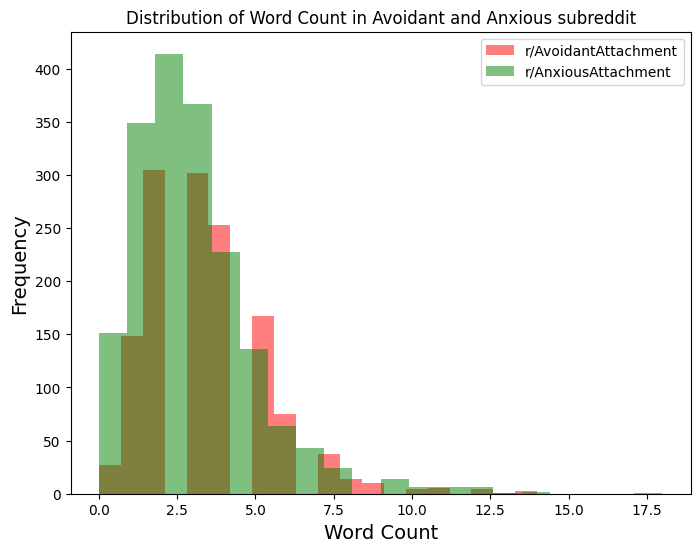

In [27]:
plt.figure(figsize = (8,6))
plt.hist(df[df['class']== 0]['post_word_count'], bins = 20, alpha = 0.5, label = 'r/AvoidantAttachment', color = 'red')
plt.hist(df[df['class']== 1]['post_word_count'], bins = 20, alpha = 0.5, label = 'r/AnxiousAttachment', color = 'green')
plt.xlabel('Word Count', size = 14)
plt.ylabel('Frequency', size = 14)
plt.title('Distribution of Word Count in Avoidant and Anxious subreddit')
plt.legend()
plt.show()

In [28]:
# Summary info of word count in Avoidant subreddit
df[df["class"] == 0]['post_word_count'].describe()

count    1355.000000
mean        3.409594
std         1.943378
min         0.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        14.000000
Name: post_word_count, dtype: float64

In [29]:
# Summary info of word count in Anxious subreddit
df[df["class"] == 1]['post_word_count'].describe()

count    1811.000000
mean        2.830480
std         2.100639
min         0.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        18.000000
Name: post_word_count, dtype: float64

In [30]:
# Top 10 longest posts in Avoidant subreddit
df[df['class'] == 0].sort_values(by='post_word_count', ascending=False)[['text_final']].head(10)

,text_final
189,fa boyfriend shower word feel feel uncomfortable thing back need feel want know stop
194,got dog month definitely he avoidant personalityabandonment issue human need patient he good boi
1226,bf month attachment da thing going feel pattern kicking fyi relationship know attachment style
1154,da song listening singing sound avoidant recognizing avoidantlike peoplecharacters thing like songsmoviesshowsgames example
65,word instagrams rising balm u calculating riskaverting avoidant moment venerability brave fa
1220,fa da da observed want complete relationship including partner behavior da individual
1092,someone im move sought anxious avoidance relationship like feel least avoidant fa
708,avoidants feel break someone feel like dont capacity want avoid communicating feeling
235,wanting relationship day going impulse know release anxiety get relationship fa
1348,three question fa trustabandonment triggered feel betrayed feel roller coaster fa


In [31]:
# Top 10 longest posts in Anxious subreddit
df[df['class'] == 1].sort_values(by='post_word_count', ascending=False)[['text_final']].head(10)

,text_final
2077,partner responsive day unresponsive day attachment issue partner average responsiveness empirical evidence responsiveness variability predicts attachment anxiety relationship
1404,quick im sorry avoidants deactivation attack want want get want meant lover friend whatever
2330,studying attachment secure stop resenting avoidant ex topic pertaining personality would help relationship better
1772,avoidant want send anxiously attached ex criticism feedback seem get tone right want
2715,sumayapoetry spoke thought share time anxious attachment make thing shouldnt im replaceable
1693,anxious case helping lift elusive veil availability issue healing instant feel good
3006,male anxious preoccupied aps screenvet partner need explicitly need reassurance attention automatic
3065,finally feeling better le anxious day nc mean da else feel way
2280,fa finally da year let good freedom feel good honoring boundary like
2526,day anxious attachment challenge day relationship anxiety rikki cloos positive provide igpodcast


The histograms showed that distribution for both subreddits are skewed to the right, indicating that most of the posts tend to be short.

Even though the maximum word count in Anxious subreddit (18 words) is higher than that in Avoidant subreddit (14 words), the average word count in Anxious subreddit (2.8 words) is shorter than that in Avoidant subreddit (3.4 words). This indicates that redditors of both subreddits are publishing posts of similar number of words, and this feature is insignificant in discerning the two subreddits. 

The longer posts in both subreddits tend to be those where the redditor share their experiences and are seeking advice/support.

#### Word Cloud - Avoidant Style

In [32]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

duplicate_word_list = list(duplicate_words_df["Duplicate Words"])
class_1_words = [word for word in tokens_class_1 if word not in duplicate_word_list]

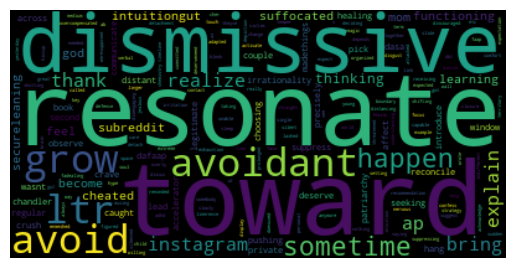

In [33]:
# Word Cloud to show the most common words that appeared in the subreddit
# For Avoidant Attachment class 0

class_0_words = [word for word in tokens_class_0 if word not in duplicate_word_list]

text = " ".join(unique_tokens_class_0)

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Word Cloud - Anxious Style

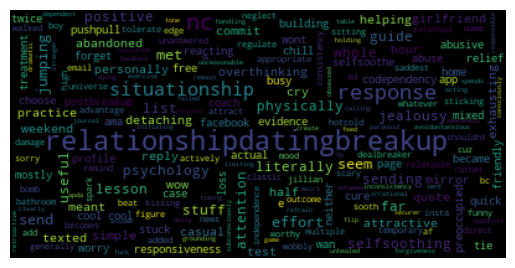

In [34]:
# Word Cloud to show the most common words that appeared in the subreddit
# For Anxious Attachment class 1
text = " ".join(class_1_words)

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Some key words found in Avoidant subreddit include "grow", "realize", "resonate". This could mean that redditors in this subreddit have realised themselves as avoidant attachment or could resonate with people of Avoidant attachment, and are seeking to grow their relationship.  

Some key words found in Anxious subreddit include "situationship", "breakup", 'overthinking'. These words could describe the experiences and feelings one with anxious attachment will have. 

#### Sentiment Analysis

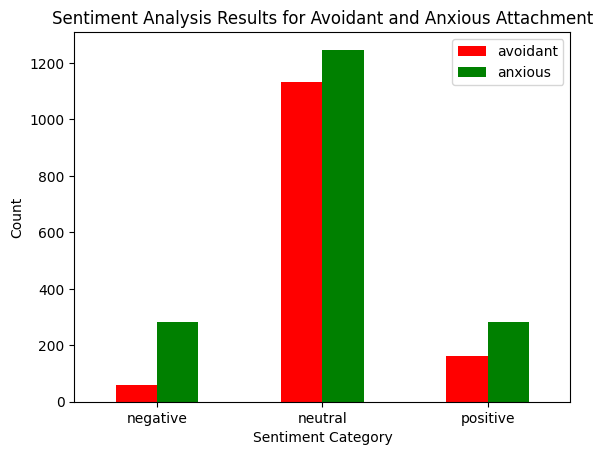

In [37]:
def get_sentiment(text):
    # create TextBlob object of passed text 
    analysis = TextBlob(text) 
    # set sentiment 
    if analysis.sentiment.polarity > 0: 
        return 'positive'
    elif analysis.sentiment.polarity == 0: 
        return 'neutral'
    else: 
        return 'negative'

df['sentiment'] = df['text_final'].apply(get_sentiment)

avoidant_sentiment_counts = df[df['class'] == 0]['sentiment'].value_counts()
anxious_sentiment_counts = df[df['class']== 1]['sentiment'].value_counts()

# Define the sentiment categories in the desired order
sentiment_categories = ['negative', 'neutral', 'positive']

# Create a DataFrame to hold the sentiment counts for both subgroups
combined_sentiment_counts = pd.DataFrame({
    'avoidant': avoidant_sentiment_counts.reindex(sentiment_categories, fill_value=0),
    'anxious': anxious_sentiment_counts.reindex(sentiment_categories, fill_value=0)
})

# Create a grouped bar plot with custom colors and category order
combined_sentiment_counts = combined_sentiment_counts.reindex(sentiment_categories)
combined_sentiment_counts.plot(kind='bar', color=['red', 'green'])


# Customize the plot
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.title('Sentiment Analysis Results for Avoidant and Anxious Attachment')
plt.xticks(rotation=0)
plt.legend
plt.show()

In [38]:
print("Sentiment count for Avoidant Attachment")
print(avoidant_sentiment_counts)
print(" ")
print("Sentiment count for Anxious Attachment")
print(anxious_sentiment_counts)

Sentiment count for Avoidant Attachment
neutral     1134
positive     161
negative      60
Name: sentiment, dtype: int64
 
Sentiment count for Anxious Attachment
neutral     1247
negative     283
positive     281
Name: sentiment, dtype: int64


The sentiment analysis results indicated that posts from both subreddits are predominantly neutral. 
<br>For the Avoidant subreddit, there are more posts with positive sentiments than negative sentiments, which aligned with the findings in the above word cloud where redditors could have identified themselves and seeking to improve. 
<br>For the Anxious subreddit, there are equal number of posts with positive and negative sentiments, which also aligned with the findings in above word cloud where redditors were sharing their experiences and feelings which are negative, while the positive sentiments could come from redditors providing support and assistance. 

## Data Modelling

We ran a series of classifier models such as Naive Bayes models (Bernoulli and Multinomial) and Logistic Regression, with different vectorization methods such as Count Vectorization and TF-IDF Vectorization, to get the optimal performance for our predictor model.   
  
Using GridSearchCV for hyperparameter tuning, we obtained the best combination of hyperparameters for optimal model performance.  

### Count Vectorizer & Bernoulli Naive Bayes Pipeline

#### Baseline Model 

In [194]:
# Initiate train, test, split function
X = df['text_final']
y = df['class']

# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=42)

In [195]:
# Create a pipeline for Count Vectorizer and Bernoulli Naive Bayes
pipe_cv_berNB = Pipeline([
    ('cvec',  CountVectorizer()),
    ('berNB', BernoulliNB())])
# Define hyperparameters for grid search
pipe_cv_berNB_params = {'cvec__max_features' : [500],  # 100
                        'cvec__ngram_range' : [(1,2)], #(1,1),(1,2),(2,2),(2,3),(3,3),(1,3)
                       'berNB__binarize': [0.0]}       # 0.1, 0.5

# Instantiate GridSearchCV
gs_cv_berNB = GridSearchCV(pipe_cv_berNB, pipe_cv_berNB_params, cv=5)

# Fit GridSearch to training data
gs_cv_berNB.fit(X_train, y_train)

# Best score
print (f'Best Score: {gs_cv_berNB.best_score_}')

# Best parameters
print (f'Best Parameters: {gs_cv_berNB.best_params_}')

# Training score
print (f'Train Score: {gs_cv_berNB.score(X_train, y_train)}')

# Test score
print (f'Test Score: {gs_cv_berNB.score(X_test, y_test)}')

# y predict
y_pred_gs_cv_berNB = gs_cv_berNB.predict(X_test)
print(classification_report(y_test, y_pred_gs_cv_berNB))

Best Score: 0.8816309127248501
Best Parameters: {'berNB__binarize': 0.0, 'cvec__max_features': 500, 'cvec__ngram_range': (1, 2)}
Train Score: 0.9001684919966302
Test Score: 0.8787878787878788
              precision    recall  f1-score   support

           0       0.94      0.76      0.84       339
           1       0.85      0.96      0.90       453

    accuracy                           0.88       792
   macro avg       0.89      0.86      0.87       792
weighted avg       0.89      0.88      0.88       792



This is the first learning model we ran and it is used as a baseline for model performance.  
Accuracy: Our model achieved an accuracy of 0.88, which means it correctly classified roughly 88% of the samples in the test dataset. It appears to perform reasonably well with an accuracy of 0.88, but it's important to predict both class accurately as each class (avoidant and anxious attachment style) have vastly different behaviours and motivations when they approach matters like conflicts and relationship matters. Thus, we want to further optimize the model or explore more advanced algorithms and feature engineering techniques to improve its performance.

### Count Vectorizer & Mutinomial Naive Bayes Pipeline

In [196]:
# Create a pipeline for Count Vectorizer and Multinomial Naive Bayes
pipe_cv_multiNB = Pipeline([
    ('cvec',  CountVectorizer()), 
    ('multiNB', MultinomialNB())])

# Define hyperparameters for grid search
pipe_cv_multiNB_params = {'cvec__max_features' : [100,500],  # comment what you have tried
                        'cvec__ngram_range' : [(1,1),(1,2),(2,2),(2,3),(3,3),(1,3)]}
                        

# Instantiate GridSearchCV    
gs_cv_multiNB = GridSearchCV(pipe_cv_multiNB, pipe_cv_multiNB_params, cv=5)

# Fit GridSearch to training data
gs_cv_multiNB.fit(X_train, y_train)

# Best score
print (f'Best Score: {gs_cv_multiNB.best_score_}')

# Best parameters
print (f'Best Parameters: {gs_cv_multiNB.best_params_}')

# Training score
print (f'Train Score: {gs_cv_multiNB.score(X_train, y_train)}')

# Test score
print (f'Test Score: {gs_cv_multiNB.score(X_test, y_test)}')

# y predict
y_pred_gs_cv_multiNB = gs_cv_multiNB.predict(X_test)
print(classification_report(y_test, y_pred_gs_cv_multiNB))

Best Score: 0.8723668665334221
Best Parameters: {'cvec__max_features': 500, 'cvec__ngram_range': (1, 1)}
Train Score: 0.9048020219039595
Test Score: 0.8813131313131313
              precision    recall  f1-score   support

           0       0.89      0.82      0.86       339
           1       0.87      0.92      0.90       453

    accuracy                           0.88       792
   macro avg       0.88      0.87      0.88       792
weighted avg       0.88      0.88      0.88       792



### Count Vectorizer & Logistic Regression Model

#### Best Model

In [197]:
def cvcvectorize_split_smote_logistic(X, y, test_size=0.4, random_state=42):
    # Step 1: Apply Count Vectorizer
    vectorizer = CountVectorizer(max_features=600, min_df=2, max_df=.9, ngram_range=(1,2))
    X_vectorized = vectorizer.fit_transform(X)
    
    # Parameters tested
    # max_features: [500, 2_000, 3_000, 4_000, 5_000]
    # min_df: [3]
    # max_df: [.95]
    # ngram_range:[(1,1) (2,2)]

    
    # Step 2: Perform train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=test_size, random_state=random_state)
    
    
    # Step 3: Apply SMOTE to the training data
    smote = SMOTE(random_state=random_state)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    
    # Step 4: Train a logistic regression model
    classifier = LogisticRegression(solver='liblinear')
    classifier.fit(X_train_resampled, y_train_resampled) 
    
    
    #Step 5: Retrieve the coefficient and feature names 
    coef = classifier.coef_[0]
    features = vectorizer.get_feature_names_out() 
    feature_importance = pd.DataFrame({'Features': features, 'Importance': coef})
    # Separate positive and negative coefficients
    positive_coeffs = feature_importance[feature_importance['Importance'] > 0]
    negative_coeffs = feature_importance[feature_importance['Importance'] < 0]
    # Find the smallest positive coefficient
    largest_positive_coeff = positive_coeffs.nlargest(50, 'Importance')
    # Find the highest negative coefficient
    smallest_negative_coeff = negative_coeffs.nsmallest(50, 'Importance')
    
    
    # Step 6: Evaluate on training and test data
    train_predictions = classifier.predict(X_train_resampled)
    test_predictions = classifier.predict(X_test)
    
    train_accuracy = accuracy_score(y_train_resampled, train_predictions)
    test_accuracy = accuracy_score(y_test, test_predictions)
    
    # Score model on training set
    print(f'Train Score: {train_accuracy}')
    
    # Score model on testing set
    print(f'Test Score: {test_accuracy}')
    
    # Making predictions
    print(classification_report(y_test, test_predictions))
    
    # Pickle out the vectorizer and the model for streamlit in the streamlit folder.
    pickle.dump(vectorizer,open('../streamlit/our_vectorizer.pkl','wb'))
    pickle.dump(classifier,open('../streamlit/our_model.pkl','wb'))
    
    return train_accuracy, test_accuracy, smallest_negative_coeff, largest_positive_coeff


# Invoke Function 
cvcvectorize_split_smote_logistic(X,y)

Train Score: 0.894090909090909
Test Score: 0.8950276243093923
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       556
           1       0.89      0.93      0.91       711

    accuracy                           0.90      1267
   macro avg       0.90      0.89      0.89      1267
weighted avg       0.90      0.90      0.89      1267



(0.894090909090909,
 0.8950276243093923,
                 Features  Importance
 179                   fa   -4.747432
 109                   da   -2.816274
 50             avoidance   -2.295773
 207                 fada   -1.905943
 142         deactivating   -1.874534
 30         ask avoidants   -1.748745
 131                 dafa   -1.662415
 455                   sa   -1.600877
 23       anxious partner   -1.473009
 290             intimacy   -1.458955
 67             avoidants   -1.275914
 52              avoidant   -1.221619
 163              emotion   -1.163432
 367               parent   -1.116756
 453                 rule   -1.077500
 15          anxiety feel   -1.056157
 512                 take   -0.997954
 49                 avoid   -0.978497
 144         deactivation   -0.969989
 118           da feeling   -0.958888
 55   avoidant attachment   -0.927890
 301                   le   -0.915653
 588                 work   -0.913937
 177              express   -0.859824
 561     

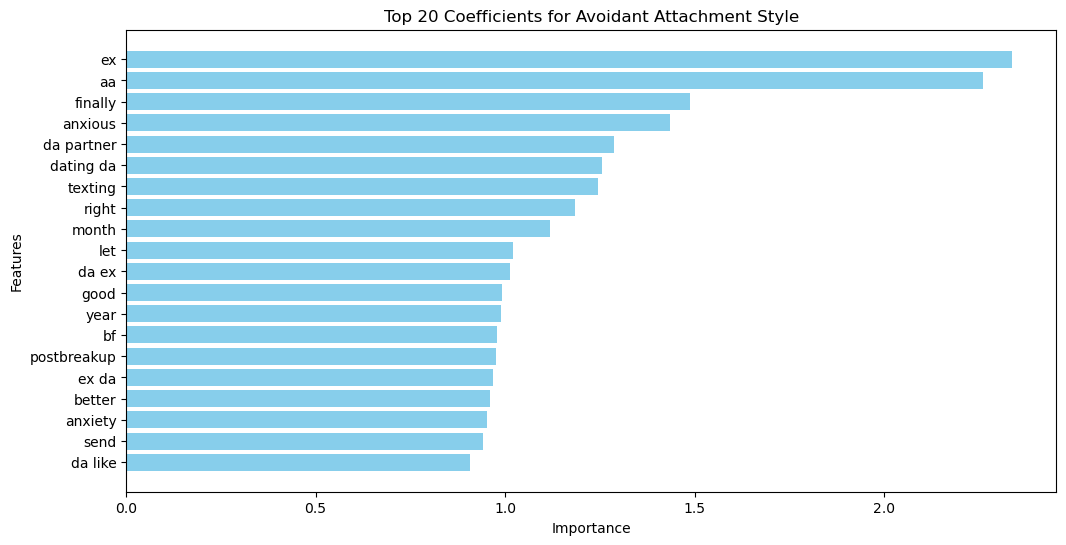

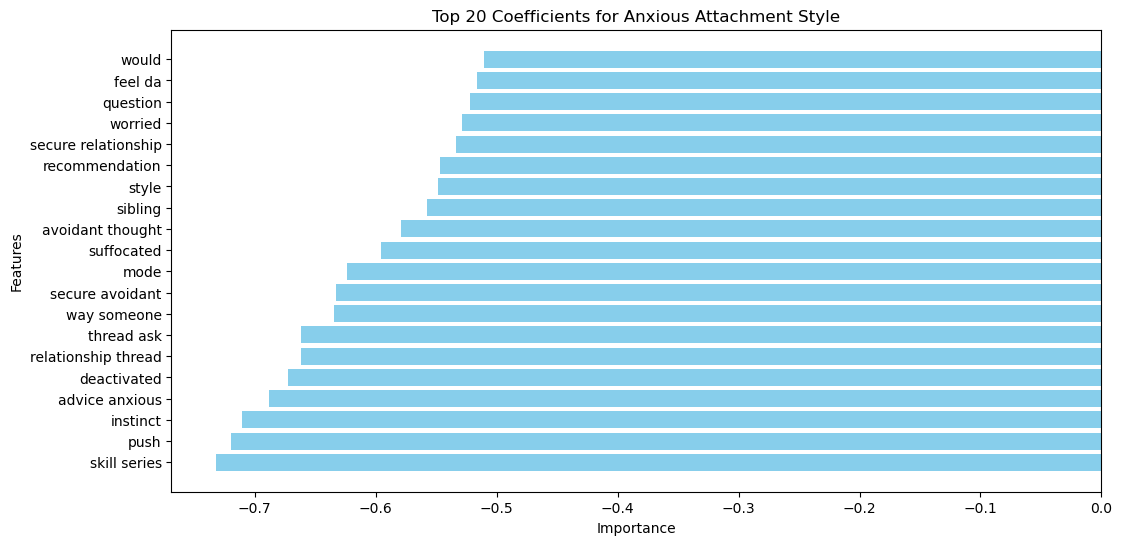

In [200]:
# Plot graph with strongest co-efficient words for each class

def plot_feature_importance(feature_importance, title):
    # Sort the feature importance values in descending order
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    # Create a bar chart
    plt.figure(figsize=(12, 6))
    plt.barh(feature_importance['Features'][:20], feature_importance['Importance'][:20], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title(title)
    plt.gca().invert_yaxis()  # Invert the y-axis to show the most important features at the top
    plt.show()

# Plot the largest positive coefficients
plot_feature_importance(largest_positive_coeff, 'Top 20 Coefficients for Avoidant Attachment Style')
# Plot the smallest negative coefficients
plot_feature_importance(smallest_negative_coeff, 'Top 20 Coefficients for Anxious Attachment Style')

Some top feature coefficients with high prediction importance for Avoidant Attachment Style are 'push', 'deactivated' and 'suffocated'while some top feature coefficients with high prediction importance for Anxious Attachment Style are 'anxiety', 'postbreakup', 'texting' and 'anxious'.

### TF-IDF Vectorizer & Logistic Regression Model

In [201]:
def tfidvectorize_split_smote_logistic(X, y, test_size=0.4, random_state=42):
    # Step 1: Apply Tfidf Vectorizer
    vectorizer = TfidfVectorizer(max_features=600, min_df=2, max_df=.9, ngram_range=(1,2))
    X_vectorized = vectorizer.fit_transform(X)
    
    # Parameters tested
    # max_features: [500, 2_000, 3_000, 4_000, 5_000]
    # min_df: [3]
    # max_df: [.95]
    # ngram_range:[(1,1) (2,2)]

    
    # Step 2: Perform train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=test_size, random_state=random_state)
    
    
    # Step 3: Apply SMOTE to the training data
    smote = SMOTE(random_state=random_state)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    
    # Step 4: Train a logistic regression model
    classifier = LogisticRegression(solver='liblinear')
    classifier.fit(X_train_resampled, y_train_resampled) 
    
    
    # Step 5: Evaluate on training and test data
    train_predictions = classifier.predict(X_train_resampled)
    test_predictions = classifier.predict(X_test)
    
    train_accuracy = accuracy_score(y_train_resampled, train_predictions)
    test_accuracy = accuracy_score(y_test, test_predictions)
    
    # Score model on training set
    print(f'Train Score: {train_accuracy}')
    
    # Score model on testing set
    print(f'Test Score: {test_accuracy}')
    
    # Making predictions
    print(classification_report(y_test, test_predictions))
    
    return train_accuracy, test_accuracy


# Invoke Function 
tfidvectorize_split_smote_logistic(X,y)

Train Score: 0.8827272727272727
Test Score: 0.8871349644830308
              precision    recall  f1-score   support

           0       0.91      0.82      0.86       556
           1       0.87      0.94      0.90       711

    accuracy                           0.89      1267
   macro avg       0.89      0.88      0.88      1267
weighted avg       0.89      0.89      0.89      1267



(0.8827272727272727, 0.8871349644830308)

## Conclusions and Recommendations

Summary Results:  
| Models | Train accuracy | Test accuracy | Precision | Recall | F1 Score | 
|----------|----------|----------|----------|----------|----------|
| Bernoulli Naive Bayes (With Count Vectorizer) | 0.90 | 0.88 | 0.85 | 0.96 | 0.90 |
| Multinomial Naive Bayes (With Count Vectorizer) | 0.90 | 0.88 | 0.87 | 0.92 | 0.90 | 
| <b>Logistic Regression (With Count Vectorizer)</b> | <b>0.90</b> | <b>0.90</b> | <b>0.89</b> | <b>0.93</b> | <b>0.91</b> |
| Logistic Regression (With TF-IDF Vectorizer) | 0.88 | 0.89 | 0.87 | 0.94 | 0.90 |

Logistic Regression model with Count Vectorizer achieved the best prediction performance amongst other classifier models and vectorization methods that we have attempted. With the application of SMOTE to upsize class 0 dataset to prevent class imbalance and GridSearchCV for hyperparameters tuning, the combination of max_features=600, min_df=2, max_df=.9, ngram_range=(1,2) gives us a train, test accuracy score of 0.9 with no overfitting or underfitting of data.  
  
Accuracy of the model is the most important criteria when we are evaluating the performance of the model. As both attachment styles handles relationship matters such as conflicts and feelings very differently, it is equally important to predict both behaviours correctly.

As reference from Columbia Psychiatry, adult attachment theory posits that your attachment style as an adult affects how you behave in close, romantic relationships and by understanding attachment styles of yourself and partner, it allows room for change and growth in improving relationships. Link: https://www.columbiapsychiatry.org/news/how-attachment-styles-influence-romantic-relationships

Recommendations:  
  
<b>Phase 1 - First release of the app on</b>:  
- MSF website  
- MSF’s Telegram channel (i.e.,MSFCares)

<b>Phase 2 - Improve accuracy of classifier model to ≥0.95 through</b>:  
- collecting more data from other similar subreddits
- exploring ways to tune the existing classifier model  
- exploring the use of other classifier models (e.g., XGBoost)
  
<b>Phase 3 - Second release of the app with</b>:  
- expanded coverage of the other two attachment styles